# Stock Price Modeling from Fundamentals

In [132]:
# Todo :
# - Create labels from stock price data before and after earnings. 
#   This should correlate the change in stock price with the change in fundamentals
# - Create validation and test sets
#   4th most recent quarter's price for validation.
#   3 most recent quarters' price for test
# - Start modeling. Try some baselines first (e.g. mean estimates, repeating previous periods)
#   Try some additional models (e.g. ARIMA, XGBoost trees)

In [133]:
from pathlib import Path
import pandas as pd

prices = pd.read_csv(Path("preprocessed") / "KMB_prices_dates.csv")
financials = pd.read_csv(Path("preprocessed") / "KMB_financials.csv")

prices.shape, financials.shape

((6282, 6), (448, 230))

In [134]:
prices["target"] = prices["Close"] - prices["Open"]
prices = prices[["Date", "target"]] # backward looking
priced = prices.sort_values(by="Date")
prices.head(3)

,Date,target
0,2001.144809,0.083130
1,2001.147541,-0.062352
2,2001.155738,0.257708


In [135]:
financials["period_end"] = financials["period_end"] 
financials.head(3)

,period_end,filing_date,form,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedAdvertisingCurrent,AccruedLiabilitiesCurrent,AccruedSalariesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLossNetOfTax,...,UnrecordedUnconditionalPurchaseObligationBalanceOnThirdAnniversary,UnrecordedUnconditionalPurchaseObligationDueAfterFiveYears,VariableLeaseCost,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesIssuedBasic,WeightedAverageNumberOfSharesOutstandingBasic,0,1,2,3
0,2006.997268,2010.150273,10-K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
1,2007.997268,2009.598361,10-Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,2007.997268,2009.846995,10-Q/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0


In [136]:
dates = pd.read_csv(Path("preprocessed") / "KMB_dates.csv")
dates.head(3)

,filing_date,report_date
0,2026.117486,2025.997268
1,2026.112022,2026.109290
2,2026.109290,2025.245902


# Setup

In [137]:
merged = prices.merge(financials, left_on="Date", right_on="period_end").sort_values(by="period_end")
merged = merged.merge(dates, left_on="Date", right_on="report_date", suffixes=("", "_drop"))
merged = merged.drop(columns=["Date", "filing_date_drop", "report_date"])
financial_cols = list(set(merged.columns) - {'0', '1', '2', '3', 'filing_date', 'form'})
binarized_form_cols = ['0', '1', '2', '3']
grouped = merged.groupby('period_end')

agg_logic = {col: 'first' for col in financial_cols}
form_logic = {col: 'max' for col in binarized_form_cols}

df_consolidated = grouped.agg({**agg_logic, **form_logic})
df_consolidated.head(3)

# X_consolidated = df_consolidated.drop(columns=["target"])
# y_consolidated = df_consolidated["target"]

dates = df_consolidated["period_end"]
years = dates.astype(int)
days = (dates - years)

days.head(3)

period_end
2016.748634    0.748634
2017.087432    0.087432
2017.245902    0.245902
Name: period_end, dtype: float64

In [138]:
def coord_to_date(year, fractional_day):
    day_of_year = int(fractional_day * 366)
    return pd.to_datetime(year, format='%Y') + pd.Timedelta(days=day_of_year - 1)

# Apply this to create a real DatetimeIndex
days.index = [coord_to_date(y, f) for y, f in zip(years, days)]
days.index

DatetimeIndex(['2016-09-29', '2017-01-31', '2017-03-31', '2017-06-29',
               '2018-12-31', '2019-09-30', '2019-12-31', '2020-03-30',
               '2020-06-30', '2020-09-29', '2020-12-31', '2021-03-31',
               '2021-06-29', '2021-09-30', '2021-12-31', '2022-01-31',
               '2022-03-31', '2022-06-29', '2022-09-30', '2023-01-31',
               '2023-03-31', '2023-06-29', '2024-01-31', '2024-09-29',
               '2024-12-31', '2025-01-31', '2025-03-31', '2025-06-29',
               '2025-07-24', '2025-09-30', '2025-12-31'],
              dtype='datetime64[ns]', freq=None)

In [139]:
full_calendar = pd.date_range(start=days.index.min(), end=days.index.max(), freq='B')
df_consolidated.index = days.index
daily = df_consolidated.reindex(full_calendar)
daily = daily.ffill()
daily = daily.drop(columns=["target"]) # construct targets for each day later in the program

daily.shape

(2415, 228)

In [140]:
y = pd.read_csv(Path("preprocessed") / "KMB_prices_floats.csv").set_index("Date")
y = y.set_index(pd.to_datetime(y.index))
y_stock_returns = (y["Close"] - y["Open"])
y_stock_returns = y_stock_returns.loc[daily.index.min():daily.index.max()]

y_stock_returns = y_stock_returns.asfreq("B")
daily = daily.loc[y_stock_returns.index]
print(y_stock_returns.shape, daily.shape)
y_stock_returns.head(3)

(2415,) (2415, 228)


Date
2016-09-29   -0.646778
2016-09-30    0.312489
2016-10-03   -0.552301
Freq: B, dtype: float64

In [141]:
holidays = y_stock_returns.isna()

daily = daily.loc[~holidays]
y_stock_returns = y_stock_returns.loc[~holidays]

daily.shape, y_stock_returns.shape

((2327, 228), (2327,))

In [142]:
X_train, X_test = daily.iloc[:-180], daily.iloc[-180:]
y_train, y_test = y_stock_returns.iloc[:-180], y_stock_returns.iloc[-180:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2147, 228), (2147,), (180, 228), (180,))

# Prediction Task  
  
Predict the day-of-earnings price movement (i.e. close price minus open price)

## Baseline

In [143]:
mean_pred = y_train.mean()
max_pred = y_train.max()
med_pred = y_train.median()
recent_pred = y_train.iloc[-1]

mean_pred, max_pred, med_pred, recent_pred,

(np.float64(0.019356951839015504),
 np.float64(10.116094515240192),
 np.float64(0.0457447740429302),
 np.float64(2.6460335936180854))

In [144]:
import numpy as np
from sklearn.metrics import root_mean_squared_error as rmse

def print_rmse(actual, pred, loss_for):
    loss = rmse(actual, pred)

    print(f"{loss_for} loss = {loss:.4f}")

def print_full_rmse(const_pred):
    print_rmse(y_train, y_train.apply(lambda x: const_pred), "Training")
    print_rmse(y_test, y_test.apply(lambda x: const_pred), "Test")

In [145]:
print("Mean baseline:")
print_full_rmse(mean_pred)
print()
print("Max baseline:")
print_full_rmse(max_pred)
print()
print("Median baseline:")
print_full_rmse(med_pred)
print()
print("Recent baseline:")
print_full_rmse(recent_pred)
print()

Mean baseline:
Training loss = 1.2401
Test loss = 1.2902

Max baseline:
Training loss = 10.1726
Test loss = 10.3431

Median baseline:
Training loss = 1.2404
Test loss = 1.2939

Recent baseline:
Training loss = 2.9047
Test loss = 3.0726



To contextualize this RMSE, the current stock price is ~$100 so the loss approximately corresponds to the percent error in estimated and actual pricing.  

## SARIMA

In [146]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_zero = pd.DataFrame(X_scaled).fillna(0) # ignored in sparse representation

svd = TruncatedSVD(n_components=25) # avoid high dimensional data by using <= 31 features. only 31 dates I care about (1 for each filing)
X_low_dim = svd.fit_transform(X_zero)
X_low_dim = pd.DataFrame(X_low_dim)
X_low_dim.shape

c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\sklearn\utils\extmath.py:1207: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\sklearn\utils\extmath.py:1212: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\sklearn\utils\extmath.py:1236: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(2147, 25)

In [147]:
!pip install statsmodels

In [148]:
X_low_dim.index = y_train.index # add back dates

y_train.shape, X_low_dim.shape

((2147,), (2147, 25))

In [149]:
!pip install pmdarima

In [150]:
import pmdarima as pm

loss_dates = list(set(X_low_dim.index).intersection(set(X_train.index)))
# SARIMAX tuning
model = pm.auto_arima(
    # Interpolate holidays (e.g. Jimmy Carter memoriam on 1.9.2025)
    # Source of bias as nans should be ignored in practice.
    y=y_train.ffill(), 
    exogenous=X_train,  
    d=0,
    seasonal=True, m=5, 
    start_p=0, max_p=5, # autoregress 2-3 weeks before earnings
    start_q=0, max_q=5, # MA 2-3 weeks before earnings
    test='kpss',   
    stepwise=True, 
    out_of_sample_size=180, # forecast next 6 months
    scoring='mse',
    n_jobs=-1
)

print(model.summary())

c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2147
Model:                        SARIMAX   Log Likelihood               -3508.748
Date:                Mon, 16 Feb 2026   AIC                           7019.497
Time:                        14:00:43   BIC                           7025.169
Sample:                             0   HQIC                          7021.572
                               - 2147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.5382      0.023     65.634      0.000       1.492       1.584
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):              3249.10
Prob(Q):                              0.42   Pr

In [151]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# This will force the model to keep all 10 PCA components
# No matter how 'useless' the auto-search thinks they are
sarimax = SARIMAX(y_train, exog=X_train.fillna(0), order=(1, 0, 1))
model = sarimax.fit(maxiter=1000)

c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting

In [152]:
train_preds = pd.Series(model.predict(start=0, end=X_train.shape[0]-1, exog=scaler.transform(X_train)))
train_preds.index = X_train.index

train_preds.shape

(2147,)

In [153]:
loss_dates = list(set(days.index).intersection(set(train_preds.index)))
train_preds_filings = train_preds[loss_dates]
train_targets_filings = y_train[loss_dates]
train_loss = rmse(train_preds_filings, train_targets_filings)

print(f"Train (including validation set) RMSE = {train_loss:.4f}")

train_preds_filings.head(3)

Train (including validation set) RMSE = 1.2237


Date
2021-09-30    0.079597
2022-06-29   -0.151777
2020-03-30   -0.008713
Name: predicted_mean, dtype: float64

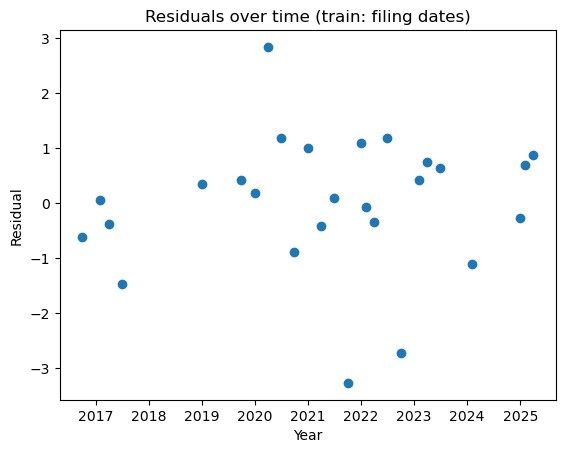

In [154]:
import matplotlib.pyplot as plt

train_residuals = train_targets_filings[loss_dates] - train_preds_filings

plt.scatter(loss_dates, train_residuals)
plt.title("Residuals over time (train: filing dates)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

Residuals are roughly normally distributed

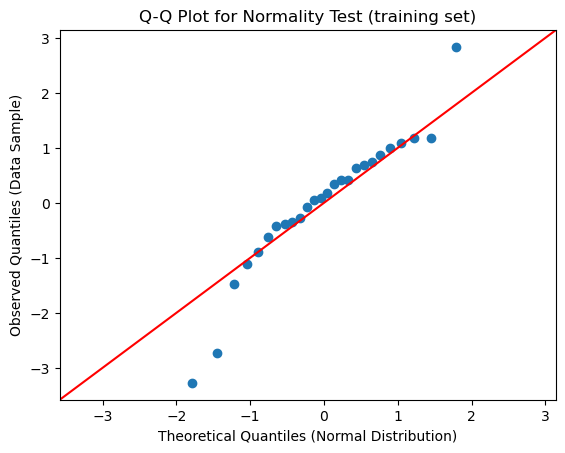

In [155]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.qqplot(train_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (training set)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()

In [156]:
test_preds = pd.Series(model.predict(start=0, end=X_test.shape[0]-1, exog=scaler.transform(X_test)))
test_preds.index = X_test.index

In [157]:
loss_dates = list(set(days.index).intersection(set(test_preds.index)))
test_preds_filings = test_preds[loss_dates]
test_targets_filings = y_test[loss_dates]
test_loss = rmse(test_preds_filings, test_targets_filings)

print(f"Test (including validation set) RMSE = {test_loss:.4f}")

Test (including validation set) RMSE = 0.9162


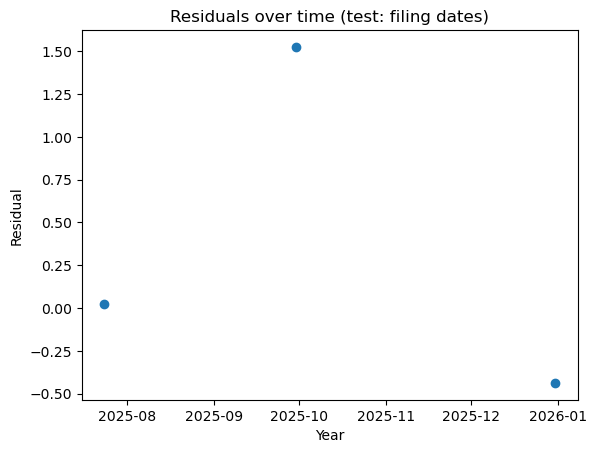

In [158]:
test_residuals = test_targets_filings[loss_dates] - test_preds_filings

plt.scatter(loss_dates, test_residuals)
plt.title("Residuals over time (test: filing dates)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

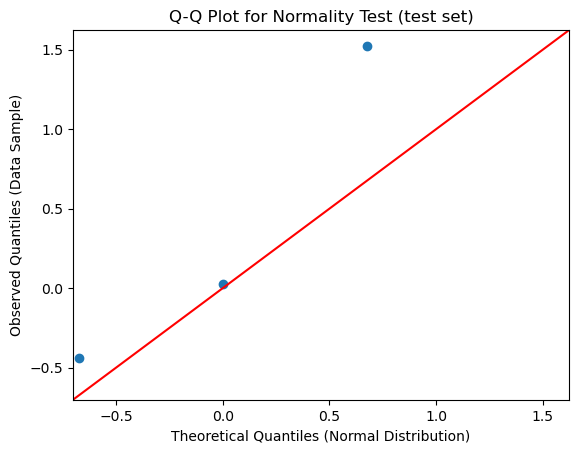

In [159]:
sm.qqplot(test_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (test set)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()

# XGBoost Tree

In [160]:
!pip install xgboost

In [161]:
import xgboost as xgb

# c.b. - add lagged features

In [162]:
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    objective='reg:squarederror',
    importance_type='gain' 
)

# Fit the model
model.fit(
    X_train.iloc[:-180], y_train.iloc[:-180],
    eval_set=[(X_test.iloc[:-180], y_test.iloc[:-180])],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [163]:
train_preds = pd.Series(model.predict(X_train))
train_preds.index = X_train.index
train_preds.head(3)

Date
2016-09-29   -0.019912
2016-09-30   -0.019912
2016-10-03   -0.019912
dtype: float32

In [164]:
loss_dates = list(set(days.index).intersection(set(train_preds.index)))
train_preds_filings = train_preds[loss_dates]
train_targets_filings = y_train[loss_dates]
train_loss = rmse(train_preds_filings, train_targets_filings)

print(f"Train (including validation set) RMSE = {train_loss:.4f}")

Train (including validation set) RMSE = 1.2205


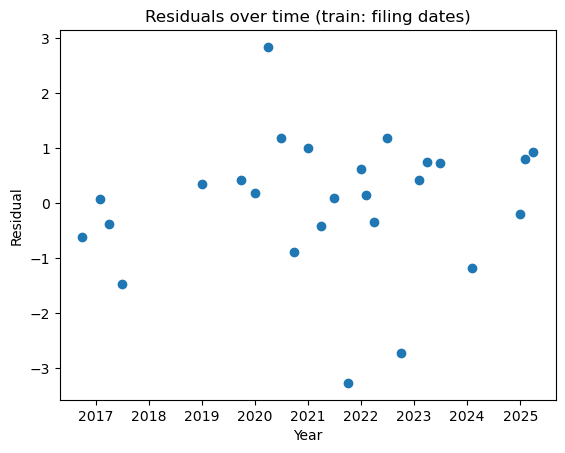

In [165]:
train_residuals = train_targets_filings[loss_dates] - train_preds_filings

plt.scatter(loss_dates, train_residuals)
plt.title("Residuals over time (train: filing dates)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

In [166]:
test_preds = pd.Series(model.predict(X_test))
test_preds.index = X_test.index
test_preds.head(3)

Date
2025-04-15   -0.011642
2025-04-16   -0.011642
2025-04-17   -0.011642
dtype: float32

In [167]:
loss_dates = list(set(days.index).intersection(set(test_preds.index)))
test_preds_filings = test_preds[loss_dates]
test_targets_filings = y_test[loss_dates]
test_loss = rmse(test_preds_filings, test_targets_filings)

print(f"Test RMSE = {test_loss:.4f}")

Test RMSE = 1.0704


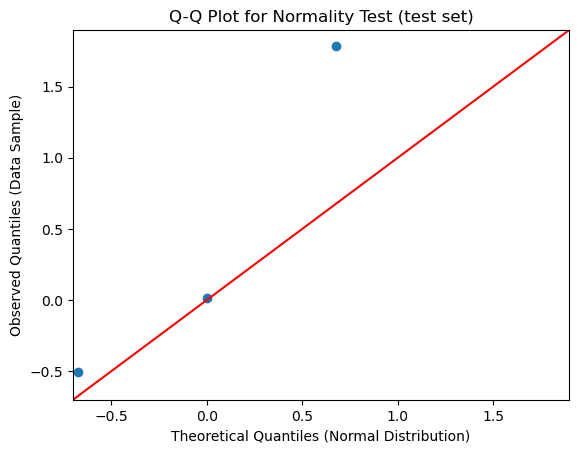

In [170]:
test_residuals = test_targets_filings[loss_dates] - test_preds_filings
sm.qqplot(test_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (test set)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()